import

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import chi2_contingency
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.stats import pearsonr


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)




데이터 불러오기

In [42]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

data processsing

In [43]:
X = train.drop(columns=['ID', 'Cancer'])
y = train['Cancer']

x_test = test.drop('ID', axis=1)

categorical_features = [col for col in X.columns if X[col].dtype == 'object']
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    for val in np.unique(x_test[col]):
        if val not in le.classes_:
            le.classes_ = np.append(le.classes_, val)
    x_test[col] = le.transform(x_test[col])

Train

데이터 구조 확인

In [44]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

train.head()

Train shape: (87159, 16)
Test shape: (46204, 15)
Train columns: ['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result', 'Cancer']
Test columns: ['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result']


,ID,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
0,TRAIN_00000,80,M,CHN,ASN,Positive,Exposed,Sufficient,Non-Smoker,Not Obese,No,0.650355,2.784735,6.744603,2.575820,1
1,TRAIN_00001,37,M,NGA,ASN,Positive,Unexposed,Sufficient,Smoker,Obese,No,2.950430,0.911624,7.303305,2.505317,1
2,TRAIN_00002,71,M,CHN,MDE,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,Yes,2.200023,0.717754,11.137459,2.381080,0
3,TRAIN_00003,40,F,IND,HSP,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,3.370796,6.846380,10.175254,0.753023,0
4,TRAIN_00004,53,F,CHN,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,4.230048,0.439519,7.194450,0.569356,1


결측지 확인

In [45]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("결측치 있는 열:\n", missing)
print(train.isnull().sum())

결측치 있는 열:
 Series([], dtype: int64)
ID                   0
Age                  0
Gender               0
Country              0
Race                 0
Family_Background    0
Radiation_History    0
Iodine_Deficiency    0
Smoke                0
Weight_Risk          0
Diabetes             0
Nodule_Size          0
TSH_Result           0
T4_Result            0
T3_Result            0
Cancer               0
dtype: int64


변수 타입 및 범주형 변수 확인

In [46]:
print(train.dtypes.value_counts())  # 타입별 컬럼 개수

categorical_cols = train.select_dtypes(include='object').columns.tolist()
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("범주형 변수:", categorical_cols)
print("수치형 변수:", numerical_cols)

object     10
float64     4
int64       2
Name: count, dtype: int64
범주형 변수: ['ID', 'Gender', 'Country', 'Race', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes']
수치형 변수: ['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result', 'Cancer']


타겟 변수 분포 확인 (`Cancer`)

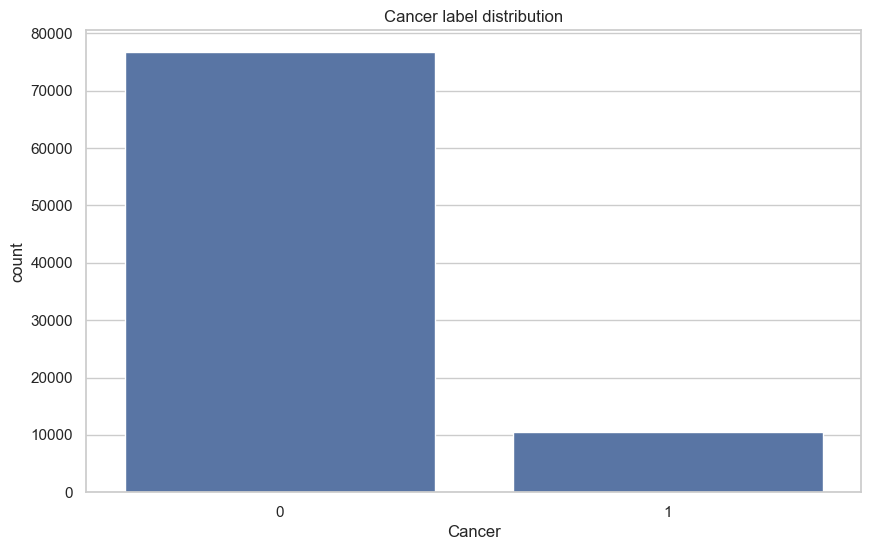

Cancer
0    0.880001
1    0.119999
Name: proportion, dtype: float64


In [47]:
sns.countplot(data=train, x='Cancer')
plt.title("Cancer label distribution")
plt.show()

print(train['Cancer'].value_counts(normalize=True))  # 비율 확인

수치형 변수 분포 탐색

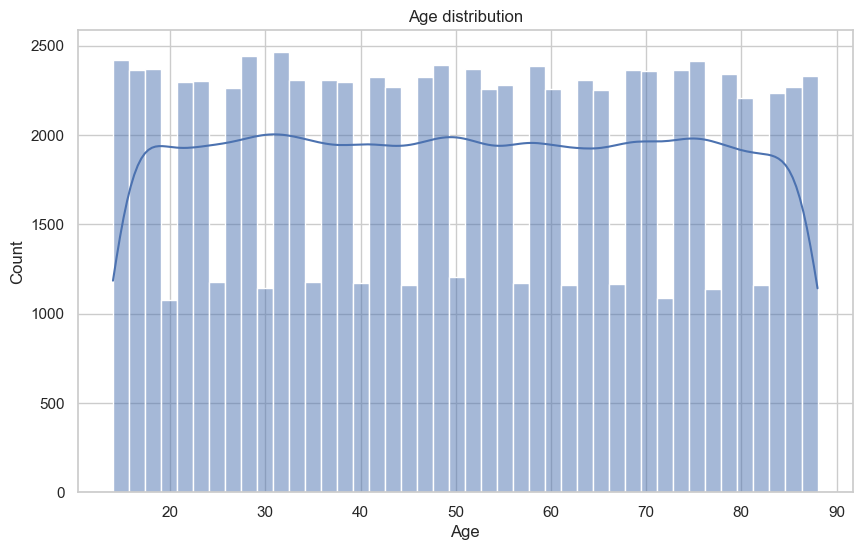

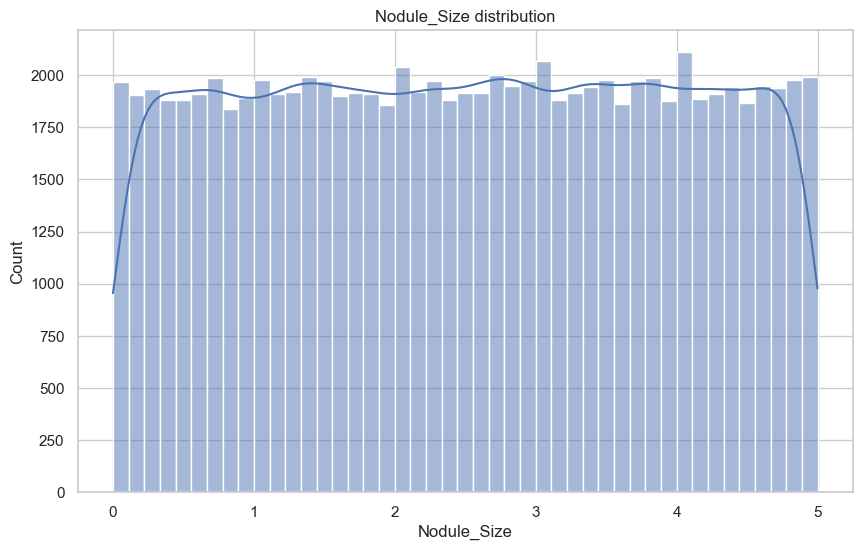

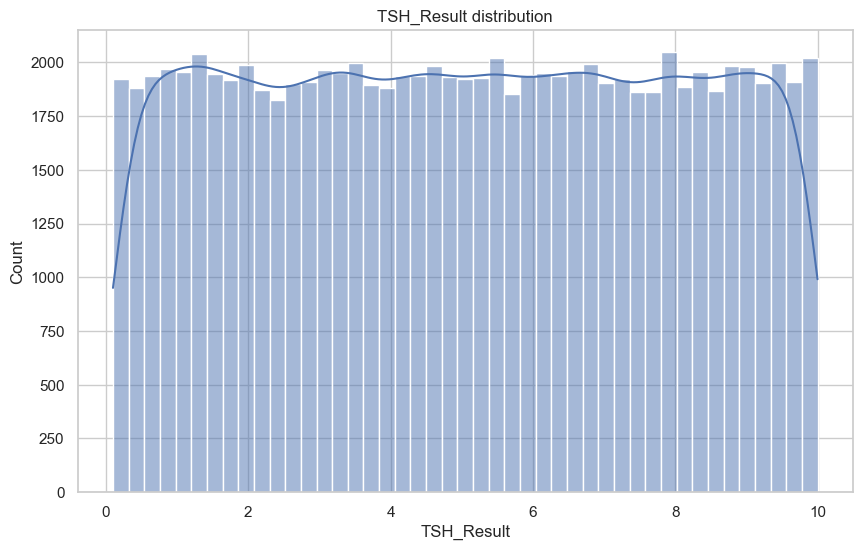

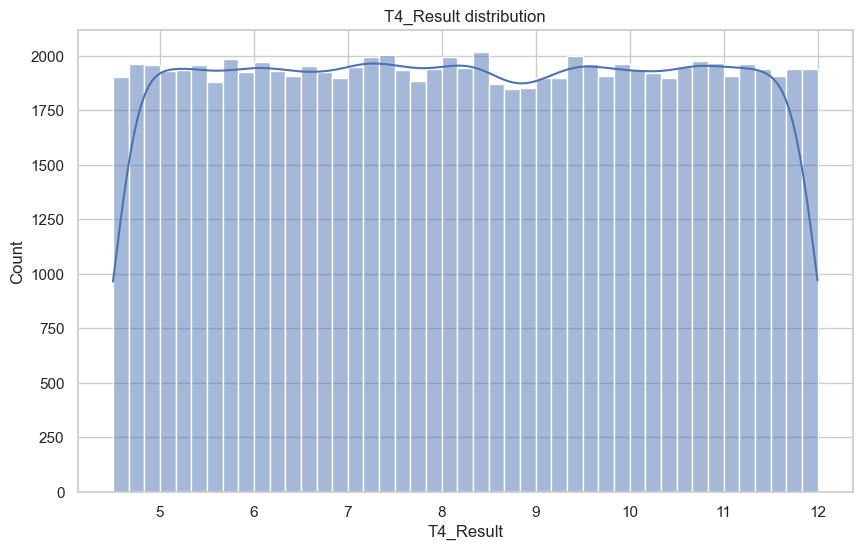

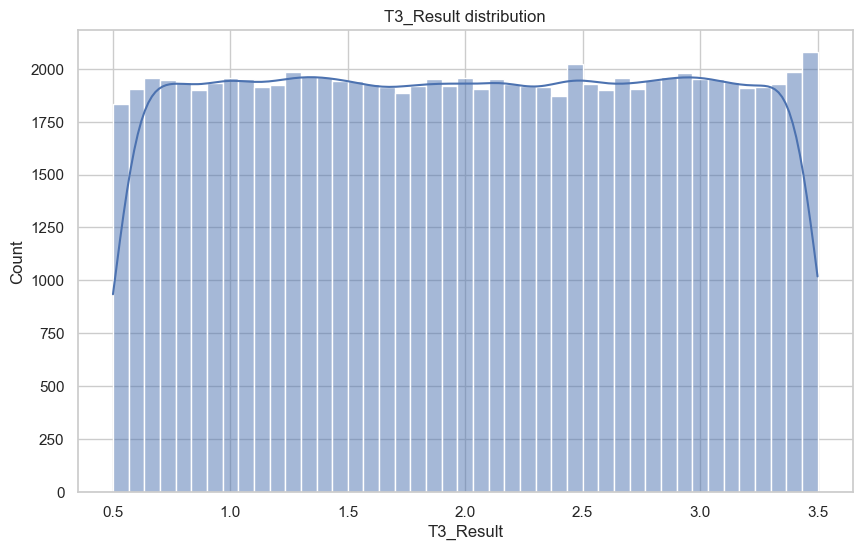

In [48]:
for col in numerical_cols:
    if col not in ['ID', 'Cancer']:
        sns.histplot(train[col], kde=True)
        plt.title(f'{col} distribution')
        plt.show()

범주형 변수 분포 확인

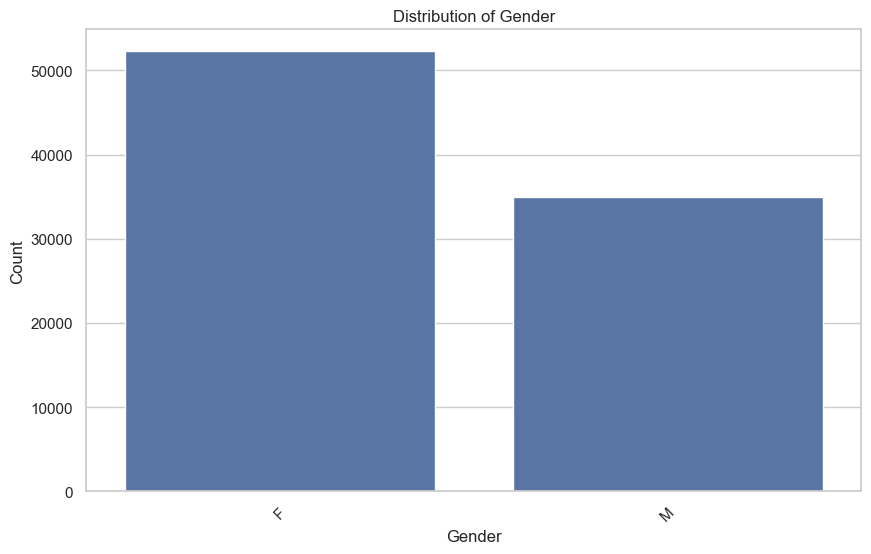

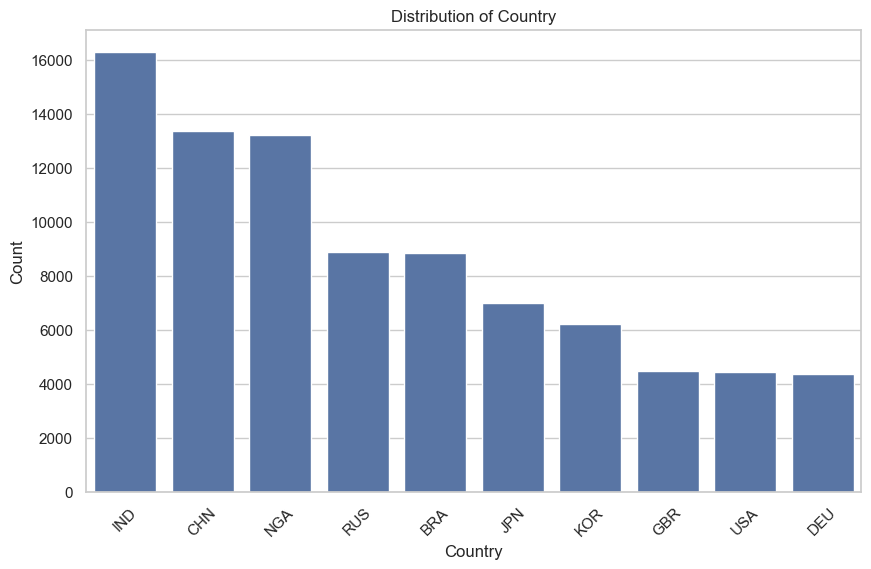

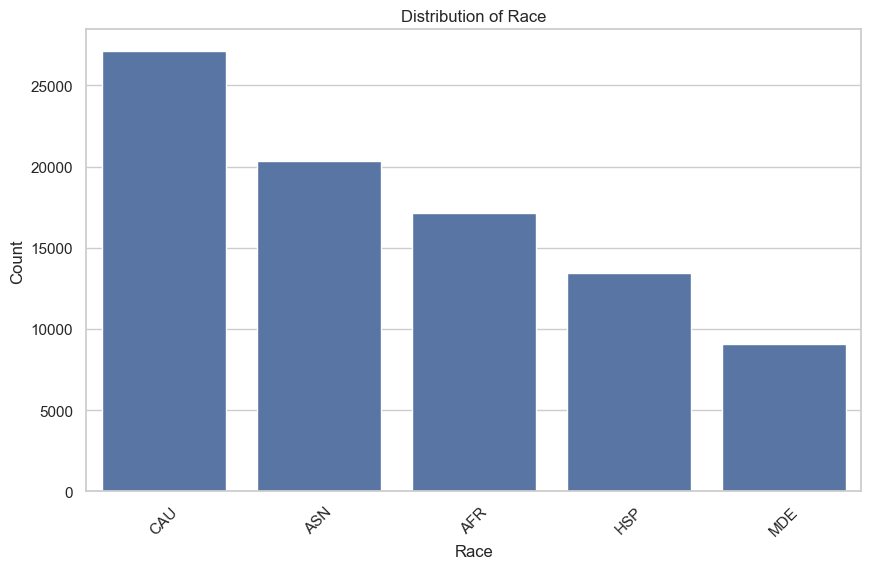

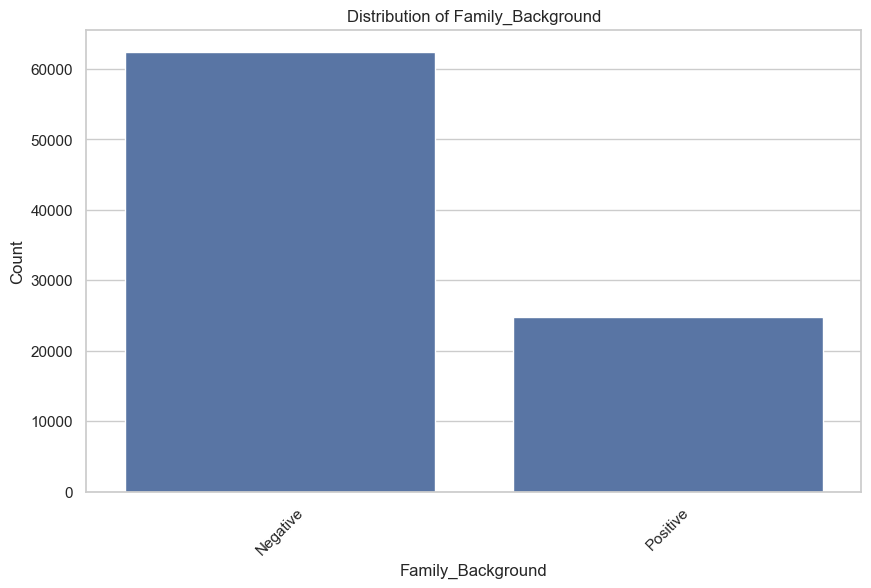

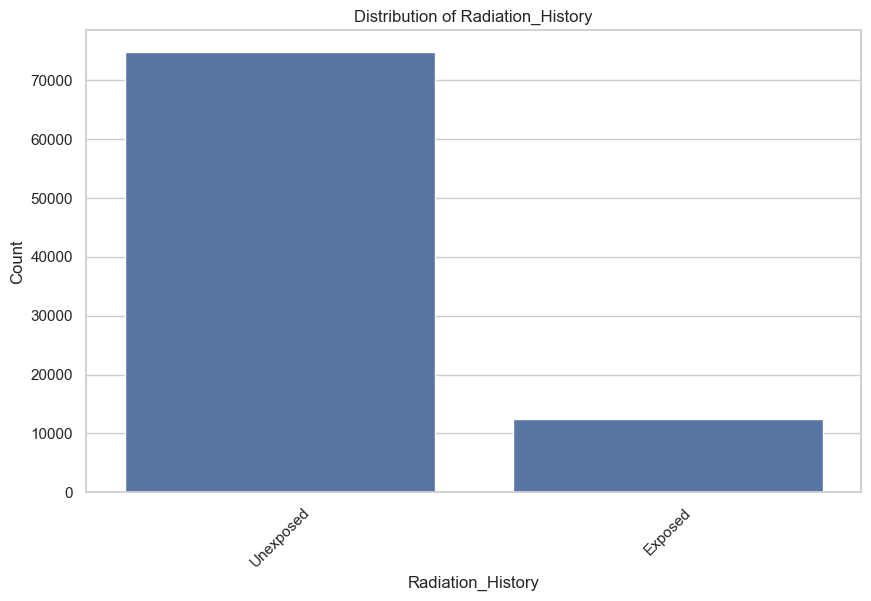

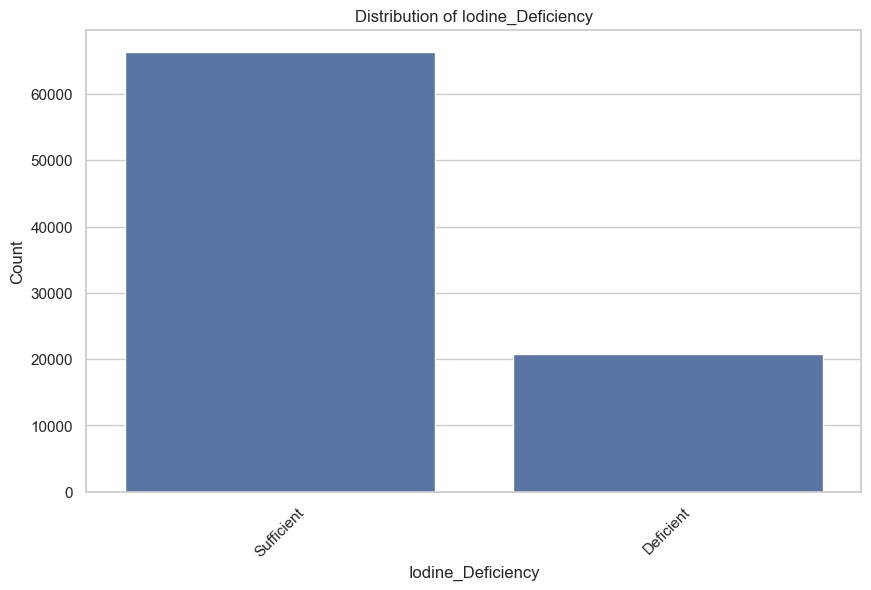

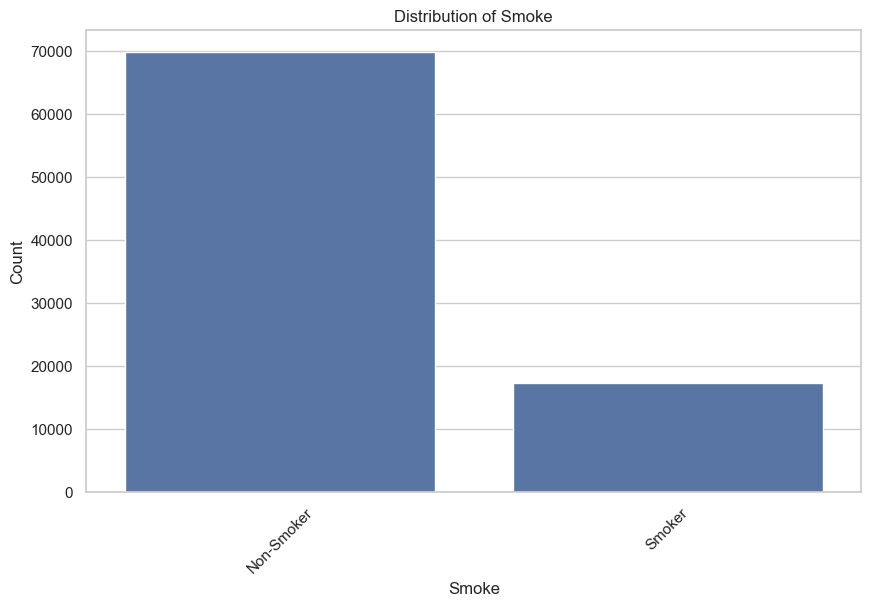

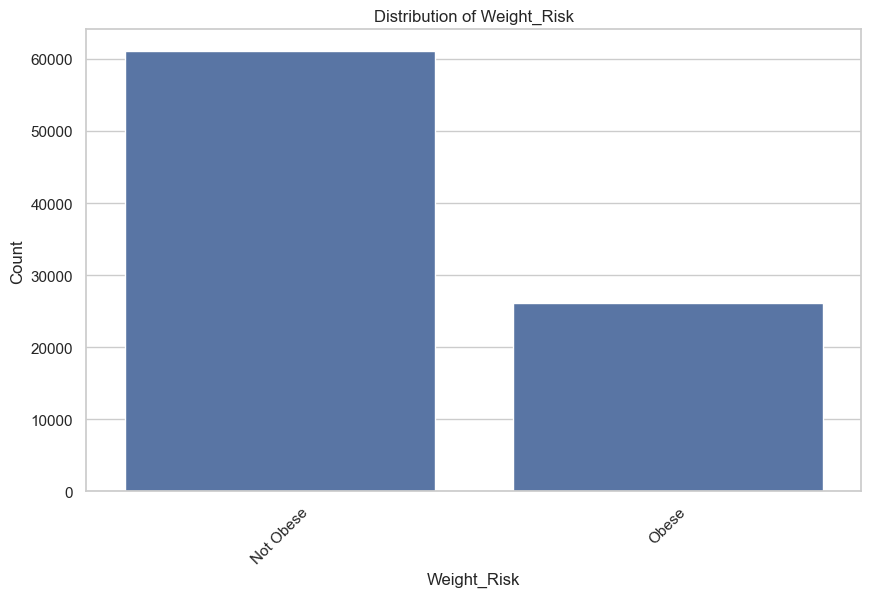

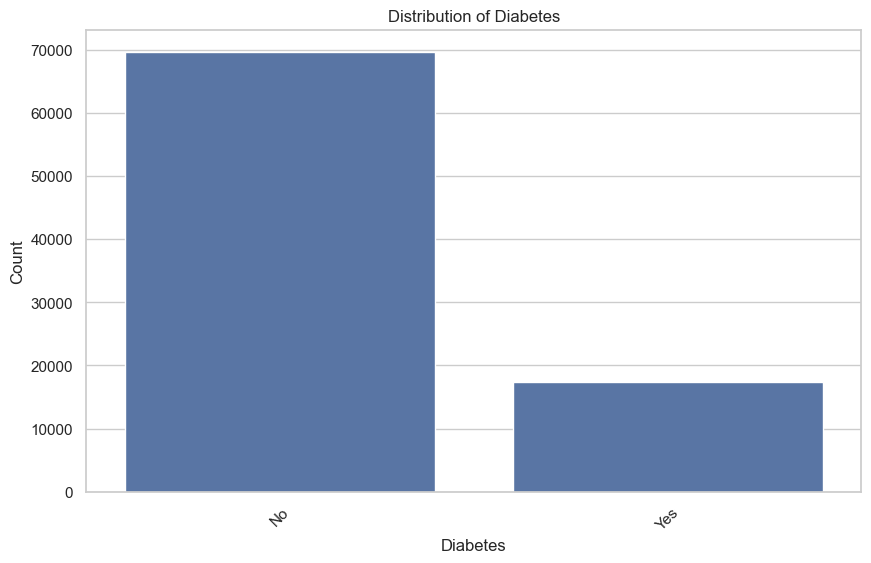

In [49]:
for col in categorical_cols:
    if train[col].nunique() <= 20:
        sns.countplot(data=train, x=col, order=train[col].value_counts().index)
        plt.title(f'Distribution of {col}')   # 영어로 출력
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()

타겟 변수와의 관계 분석             수치형 vs 타겟

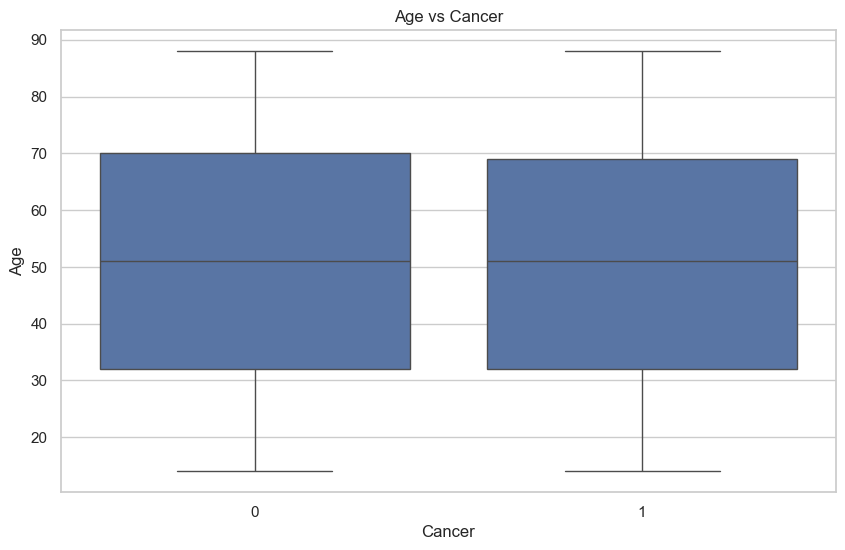

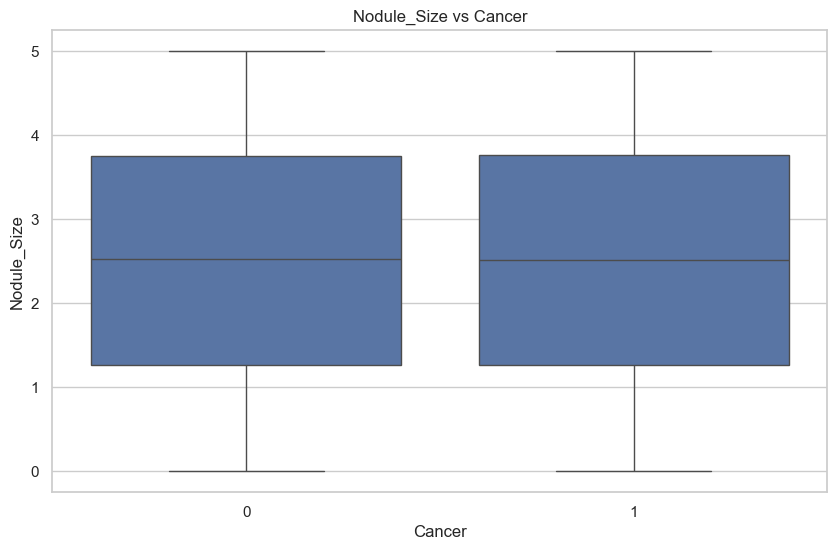

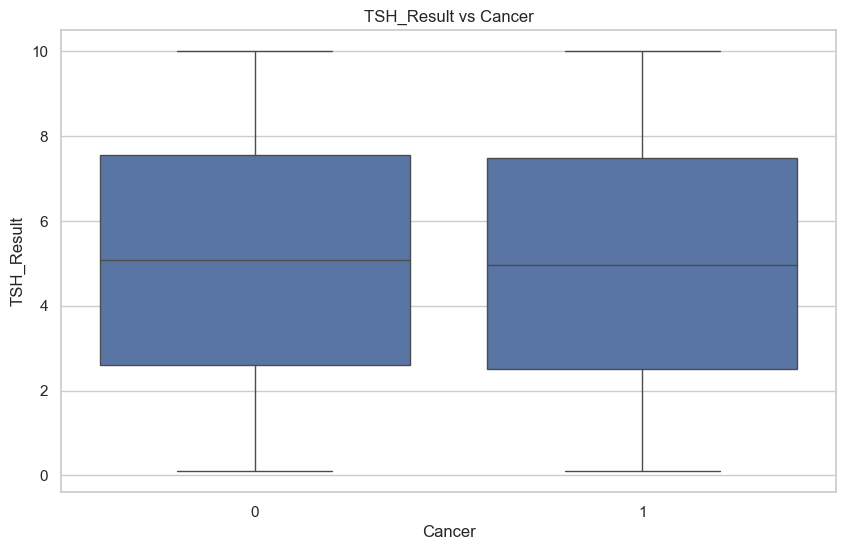

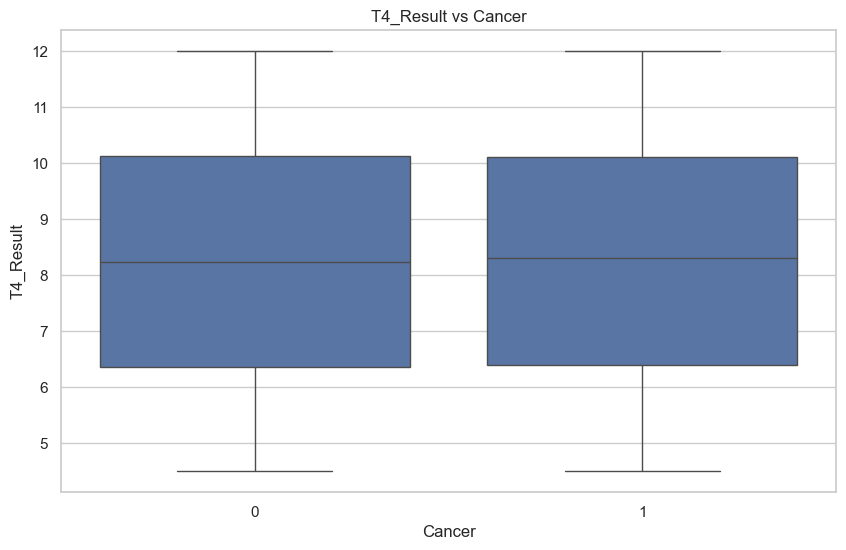

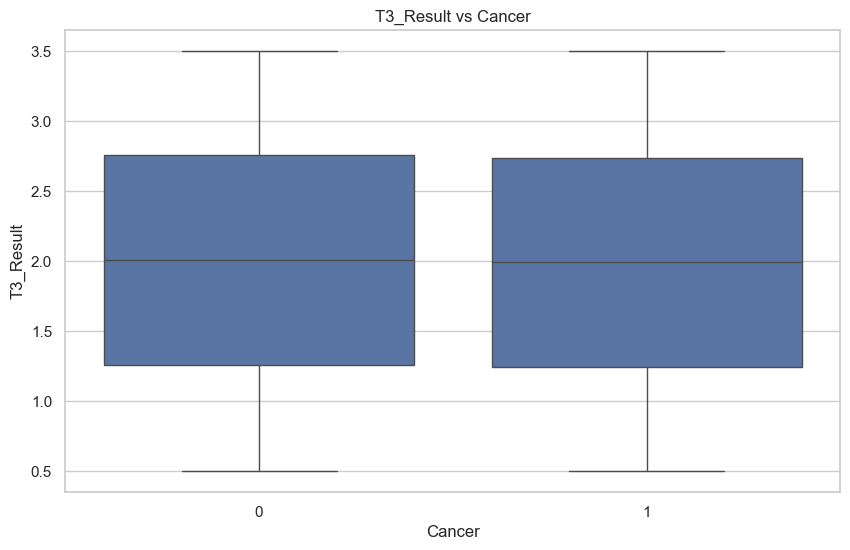

In [50]:
for col in numerical_cols:
    if col not in ['ID', 'Cancer']:
        sns.boxplot(data=train, x='Cancer', y=col)
        plt.title(f'{col} vs Cancer')
        plt.show()

범주형 vs 타겟

In [ ]:
for col in categorical_cols:
    # 고카디널리티 방지: 고유값이 20개를 초과하면 스킵
    if train[col].nunique() > 30:
        print(f"Skipping {col} (too many categories: {train[col].nunique()})")
        continue

    ct = pd.crosstab(train[col], train['Cancer'], normalize='index')
    ct.plot(kind='bar', stacked=True)
    plt.title(f'Cancer ratio by {col}')    # ✅ 영어 제목
    plt.ylabel('Ratio')                    # ✅ 영어 y축
    plt.xlabel(col)                        # ✅ 영어 x축
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Cancer Rate 

In [52]:
for col in categorical_cols:
    cancer_rate = train.groupby(col)['Cancer'].value_counts(normalize=True).unstack().fillna(0)
    cancer_rate.columns = ['Cancer=0', 'Cancer=1']  # 컬럼 이름 변경: 0은 음성, 1은 양성
    print(f"--- {col}의 Cancer rate ---")
    print(cancer_rate)
    print("\n")
   

--- ID의 Cancer rate ---
             Cancer=0  Cancer=1
ID                             
TRAIN_00000       0.0       1.0
TRAIN_00001       0.0       1.0
TRAIN_00002       1.0       0.0
TRAIN_00003       1.0       0.0
TRAIN_00004       0.0       1.0
...               ...       ...
TRAIN_87154       0.0       1.0
TRAIN_87155       1.0       0.0
TRAIN_87156       1.0       0.0
TRAIN_87157       0.0       1.0
TRAIN_87158       1.0       0.0

[87159 rows x 2 columns]


--- Gender의 Cancer rate ---
        Cancer=0  Cancer=1
Gender                    
F       0.880168  0.119832
M       0.879751  0.120249


--- Country의 Cancer rate ---
         Cancer=0  Cancer=1
Country                    
BRA      0.894422  0.105578
CHN      0.896761  0.103239
DEU      0.895482  0.104518
GBR      0.893622  0.106378
IND      0.815501  0.184499
JPN      0.898216  0.101784
KOR      0.891622  0.108378
NGA      0.893924  0.106076
RUS      0.888037  0.111963
USA      0.906089  0.093911


--- Race의 Cancer rate ---
 

상관관계 분석


In [53]:
import scipy.stats as stats

numerical_cols = ['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result', 'Cancer']

# 상관계수 계산 (피어슨 상관계수)과 p-value 계산
correlation_table = train[numerical_cols].corr()

# 'Cancer'와 다른 수치형 변수 간의 상관관계만 출력
cancer_corr = correlation_table['Cancer'].drop('Cancer')

# p-value 계산
p_values = {}
for col in numerical_cols[:-1]:  # 마지막 열은 'Cancer'이므로 제외
    corr, p_value = stats.pearsonr(train[col], train['Cancer'])
    p_values[col] = p_value

# 결과 출력
print("Correlation between numerical features and Cancer:")
for col, corr in cancer_corr.items():
    print(f"{col}: Correlation = {corr:.4f}, p-value = {p_values[col]:.4f}")
    print("\n")

# 범주형 변수와 타겟 변수의 상관관계

# 각 범주형 변수에 대해 'Cancer'=1 비율 계산
cancer_rate_by_category = {}

for col in categorical_cols:
    cancer_rate_by_category[col] = train.groupby(col)['Cancer'].mean()  # 각 범주별 Cancer의 평균 = Cancer=1 비율

# 결과 출력
print("Cancer rate by categorical features:")
for col, rate in cancer_rate_by_category.items():
    print(f"{col}:")
    print(rate)
    print("\n")

Correlation between numerical features and Cancer:
Age: Correlation = -0.0009, p-value = 0.7969


Nodule_Size: Correlation = 0.0011, p-value = 0.7512


TSH_Result: Correlation = -0.0082, p-value = 0.0152


T4_Result: Correlation = 0.0033, p-value = 0.3295


T3_Result: Correlation = -0.0035, p-value = 0.2969


Cancer rate by categorical features:
ID:
ID
TRAIN_00000    1.0
TRAIN_00001    1.0
TRAIN_00002    0.0
TRAIN_00003    0.0
TRAIN_00004    1.0
              ... 
TRAIN_87154    1.0
TRAIN_87155    0.0
TRAIN_87156    0.0
TRAIN_87157    1.0
TRAIN_87158    0.0
Name: Cancer, Length: 87159, dtype: float64


Gender:
Gender
F    0.119832
M    0.120249
Name: Cancer, dtype: float64


Country:
Country
BRA    0.105578
CHN    0.103239
DEU    0.104518
GBR    0.106378
IND    0.184499
JPN    0.101784
KOR    0.108378
NGA    0.106076
RUS    0.111963
USA    0.093911
Name: Cancer, dtype: float64


Race:
Race
AFR    0.136229
ASN    0.185975
CAU    0.087781
HSP    0.086037
MDE    0.087885
Name: Cancer, dty

모델 학습

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ---------------------- 데이터 분할 ----------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ID 열 제거
for df in [X_train, X_val, x_test]:
    if 'ID' in df.columns:
        df.drop(columns=['ID'], inplace=True)

# ---------------------- 범주형 변수 처리 ----------------------
categorical_cols = [
    'Gender', 'Country', 'Race', 'Family_Background',
    'Radiation_History', 'Iodine_Deficiency',
    'Smoke', 'Weight_Risk', 'Diabetes'
]

def safe_get_dummies(df, base_cols):
    actual_cols = [col for col in base_cols if col in df.columns]
    return pd.get_dummies(df, columns=actual_cols, drop_first=True)

X_train = safe_get_dummies(X_train, categorical_cols)
X_val = safe_get_dummies(X_val, categorical_cols)
x_test = safe_get_dummies(x_test, categorical_cols)

# ---------------------- 열 정렬 일치 ----------------------
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, x_test = X_train.align(x_test, join='left', axis=1, fill_value=0)

# ---------------------- 상호작용 변수 추가 ----------------------
def add_interaction_features(df):
    df['Age_tsh_interaction'] = df['Age'] * df['TSH_Result']
    df['Age_tsh_ratio'] = df['Age'] / (df['TSH_Result'] + 1)
    df['Nodule_Size_tsh_interaction'] = df['Nodule_Size'] * df['TSH_Result']
    df['Family_Background_tsh_interaction'] = df.get('Family_Background_Missing', 0) / (df['TSH_Result'] + 1)
    df['Iodine_Deficiency_tsh_interaction'] = df.get('Iodine_Deficiency_Yes', 0) * df['TSH_Result']
    df['Weight_Risk_tsh_interaction'] = df.get('Weight_Risk_High', 0) / (df['TSH_Result'] + 1)
    df['Gender_tsh_interaction'] = df.get('Gender_Male', 0) * df['TSH_Result']
    df['Country_tsh_interaction'] = df.get('Country_US', 0) * df['TSH_Result']
    return df

X_train = add_interaction_features(X_train)
X_val = add_interaction_features(X_val)
x_test = add_interaction_features(x_test)

# ---------------------- 클래스 불균형 보정 ----------------------
neg, pos = y_train.value_counts()[0], y_train.value_counts()[1]
scale_pos_weight = neg / pos
print(f"📌 scale_pos_weight = {scale_pos_weight:.2f}")

# ---------------------- LightGBM 모델 학습 ----------------------
model = LGBMClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# ---------------------- Threshold 최적화 ----------------------
y_val_proba = model.predict_proba(X_val)[:, 1]
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.1, 0.9, 0.01):
    y_val_pred = (y_val_proba > t).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\n✅ 최적 Threshold: {best_thresh:.2f}, Validation F1-score: {best_f1:.4f}")

📌 scale_pos_weight = 7.33
[LightGBM] [Info] Number of positive: 8367, number of negative: 61360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 69727, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119997 -> initscore=-1.992463
[LightGBM] [Info] Start training from score -1.992463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

실험

정리

In [55]:
from pandas.api.types import is_numeric_dtype
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

def feature_target_relationship(X, y, max_cat_unique=30):
    results = []

    for col in X.columns:
        x = X[col]
        if x.isnull().all():
            continue
        
        # 수치형 변수 처리
        if is_numeric_dtype(x):
            try:
                mi = mutual_info_classif(X[[col]].fillna(0), y, discrete_features=False)[0]
                f_val, p_val = f_classif(X[[col]].fillna(0), y)
                results.append({
                    "Feature": col,
                    "Type": "Numeric",
                    "Mutual Info": mi,
                    "F-statistic": f_val[0],
                    "p-value": p_val[0],
                    "Cramér’s V": np.nan,
                    "Chi² p-value": np.nan
                })
            except Exception as e:
                print(f"[Numeric Error] {col}: {e}")

        # 범주형 변수 처리 (문자열 또는 범주형 데이터 처리)
        elif x.dtype == "object" or isinstance(x.dtype, pd.api.types.CategoricalDtype):
            try:
                # 범주형 변수: 결측치를 "Missing"으로 대체하고, 정수 인코딩을 수행
                x_cat = x.fillna("Missing").astype("category")  # 명시적으로 범주형 처리
                confusion = pd.crosstab(x_cat, y)
                cramer_v = cramers_v(confusion)
                chi2_stat, chi2_p, _, _ = chi2_contingency(confusion)

                # mutual_info에 넣기 위해 정수 인코딩
                x_encoded = x_cat.cat.codes
                mi = mutual_info_classif(x_encoded.values.reshape(-1, 1), y, discrete_features=True)[0]

                results.append({
                    "Feature": col,
                    "Type": "Categorical",
                    "Mutual Info": mi,
                    "F-statistic": np.nan,
                    "p-value": np.nan,
                    "Cramér’s V": cramer_v,
                    "Chi² p-value": chi2_p
                })
            except Exception as e:
                print(f"[Categorical Error] {col}: {e}")

    # 결과 DataFrame 생성 및 정렬
    df_result = pd.DataFrame(results)
    df_result = df_result.sort_values(by="Mutual Info", ascending=False)

    return df_result
feature_target_relationship(X,y)

,Feature,Type,Mutual Info,F-statistic,p-value,Cramér’s V,Chi² p-value
6,Iodine_Deficiency,Numeric,0.017559,560.510163,1.602263e-123,NaN,NaN
5,Radiation_History,Numeric,0.015353,492.052209,1.020885e-108,NaN,NaN
3,Race,Numeric,0.011506,621.703226,9.639806e-137,NaN,NaN
4,Family_Background,Numeric,0.008207,1012.922630,5.202225e-221,NaN,NaN
1,Gender,Numeric,0.008047,0.031374,8.594085e-01,NaN,NaN
2,Country,Numeric,0.006030,1.340160,2.470090e-01,NaN,NaN
8,Weight_Risk,Numeric,0.003756,0.451600,5.015781e-01,NaN,NaN
9,Diabetes,Numeric,0.002542,0.007454,9.311989e-01,NaN,NaN
7,Smoke,Numeric,0.001532,0.038954,8.435411e-01,NaN,NaN
0,Age,Numeric,0.000888,0.066239,7.968937e-01,NaN,NaN


Train과 Test 데이터 간 분포 비교 (데이터 누수 방지용)

In [ ]:
for col in numerical_cols:
    if col != 'Cancer':
        sns.kdeplot(train[col], label='Train', fill=True)
        sns.kdeplot(test[col], label='Test', fill=True)
        plt.title(f'{col} - Train vs Test')
        plt.legend()
        plt.show()

for col in categorical_cols:
    train_freq = train[col].value_counts(normalize=True)
    test_freq = test[col].value_counts(normalize=True)
    freq_df = pd.DataFrame({'Train': train_freq, 'Test': test_freq}).fillna(0)
    freq_df.plot(kind='bar')
    plt.title(f'{col} 비율 - Train vs Test')
    plt.xticks(rotation=45)
    plt.show()

predict

In [73]:
x_test_proba = model.predict_proba(x_test)[:, 1]

submission

In [74]:
submission = pd.read_csv("sample_submission.csv")
submission["Cancer"] = (x_test_proba > best_thresh).astype(int)
submission.to_csv("submission_xgb_final.csv", index=False)
print("📤 제출 완료: submission_xgb_final.csv")

📤 제출 완료: submission_xgb_final.csv
